### Import Necessary Libraries

In [25]:
import warnings
import numpy as np
import pandas as pd
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

### Data Collection

In [4]:
path = r"/kaggle/input/adni-extracted-axial/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [5]:

class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [6]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [7]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")
    
print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [8]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


### Data Visualization

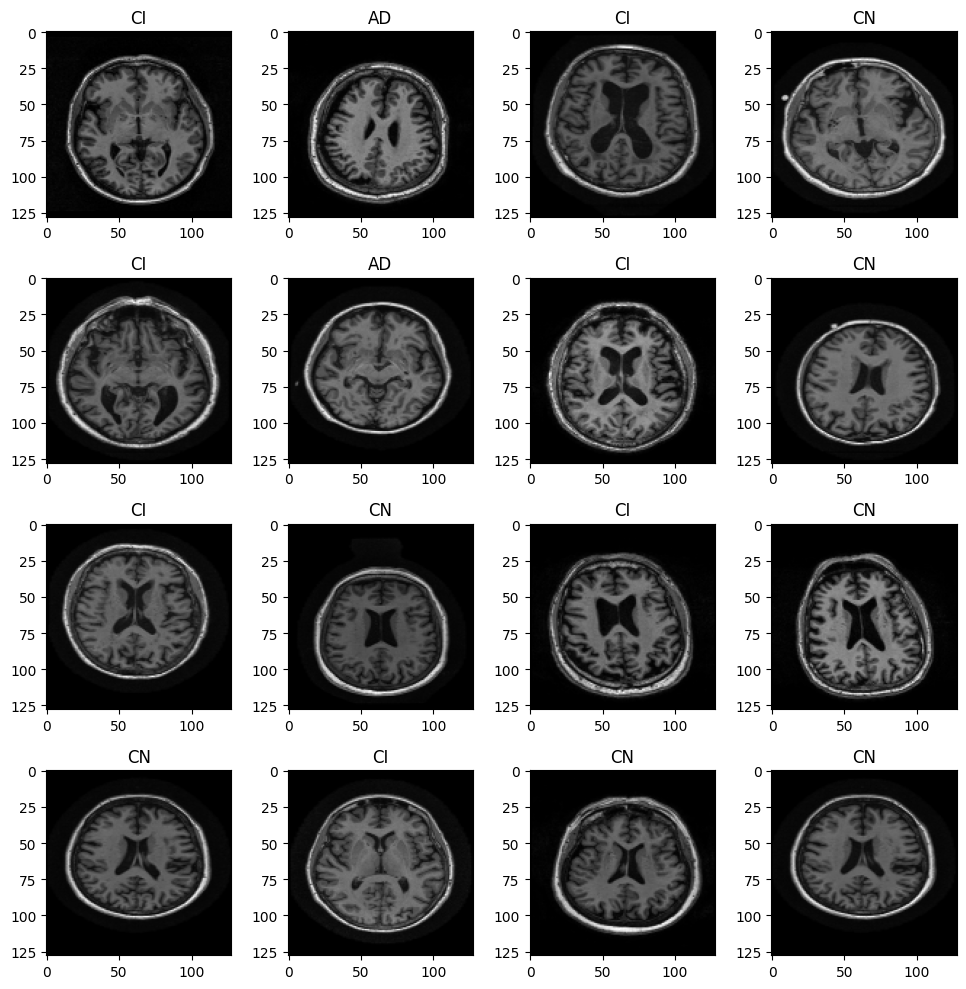

In [13]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

CI


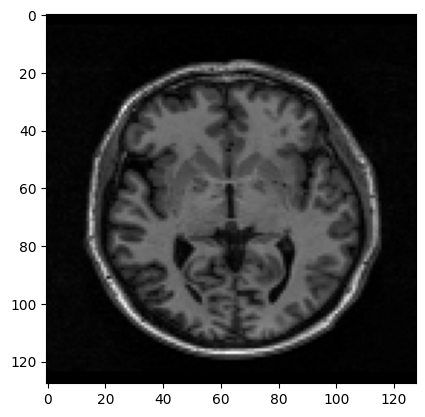

AD


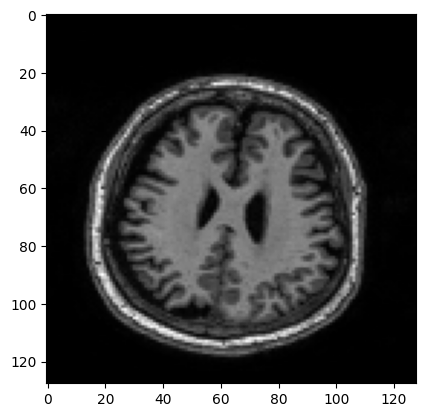

CN


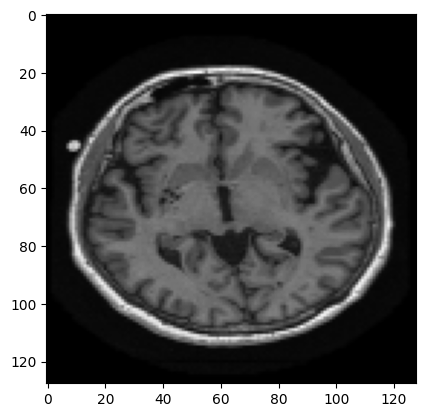

In [14]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [14]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


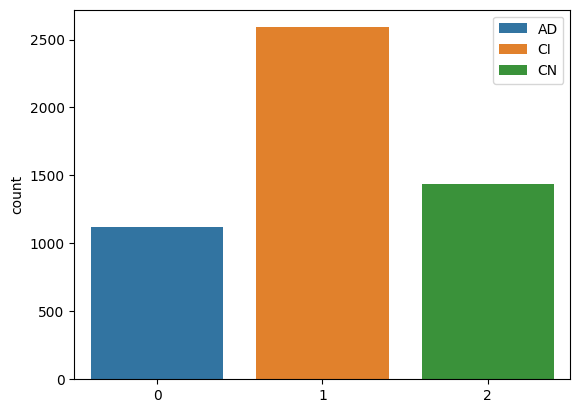

In [15]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

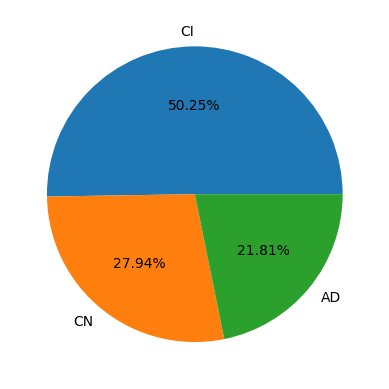

In [16]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()


### Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [18]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1
        
X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [19]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [20]:
print(pd.Series(y).value_counts())

2    3002
1    3002
0    3002
Name: count, dtype: int64


### Data Preprocessing and Preparation

In [21]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [30]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15, 
                                                                            random_state = 3, stratify = y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15, 
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6506, 128, 128, 1) (1149, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9006
Train instances: 6506           
Validation instances: 1149
Test instances: 1351


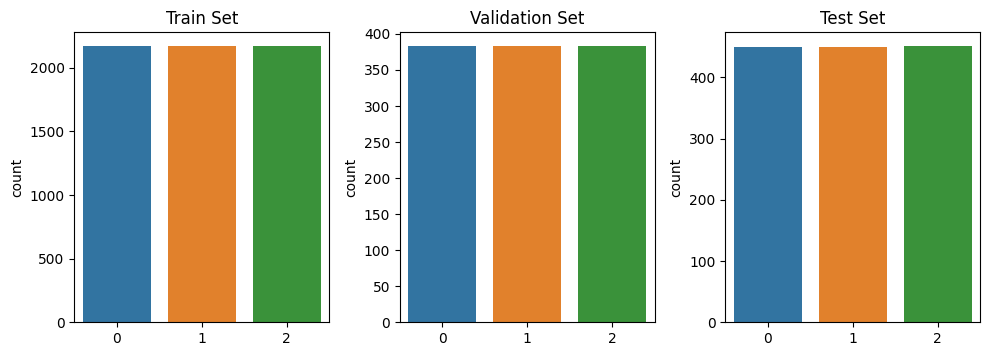

In [22]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

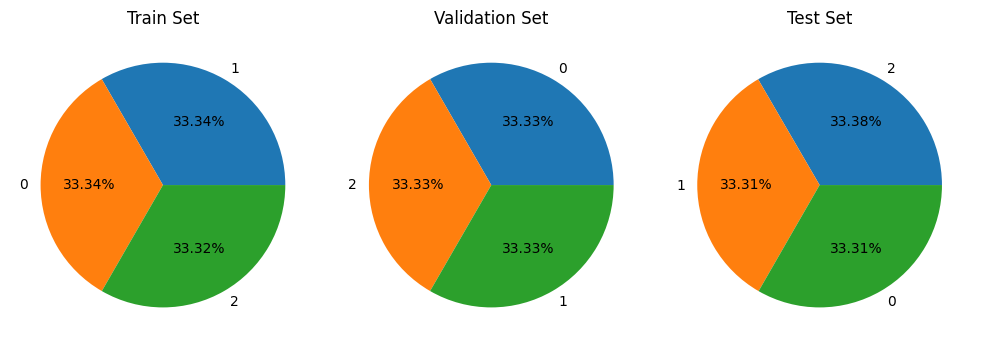

In [23]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

### Model Building and Training

In [24]:
# Model building

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
   
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 100, activation = "relu"),
    tf.keras.layers.Dense(units = 50, activation = "relu"),
    tf.keras.layers.Dense(units = 3, activation = "softmax")
])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 200)     2000      
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 200)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 100)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16900)             0         
                                                                 
 dense (Dense)               (None, 100)              

In [26]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output_shape, layer.count_params())

Layer 0: conv2d (None, 126, 126, 200) 2000
Layer 1: max_pooling2d (None, 42, 42, 200) 0
Layer 2: conv2d_1 (None, 40, 40, 100) 180100
Layer 3: max_pooling2d_1 (None, 13, 13, 100) 0
Layer 4: flatten (None, 16900) 0
Layer 5: dense (None, 100) 1690100
Layer 6: dense_1 (None, 50) 5050
Layer 7: dense_2 (None, 3) 153


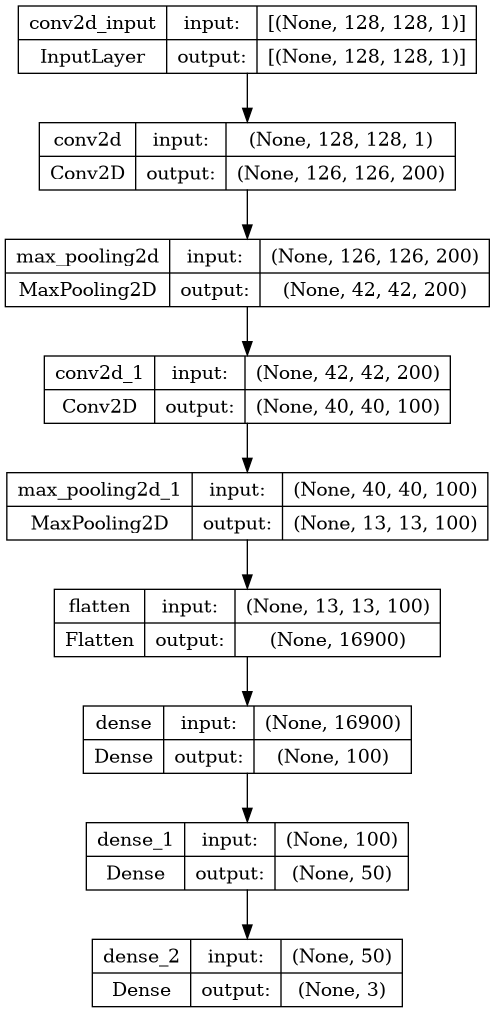

In [27]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

In [32]:
# Model compilation

model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [33]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.h5", save_best_only = True)
cb2 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 100, callbacks = [cb1, cb2], validation_data = (X_val, y_val))

Epoch 1/100
204/204 [==============================] - 7s 24ms/step - loss: 0.0199 - accuracy: 0.9939 - val_loss: 0.1333 - val_accuracy: 0.9661
Epoch 2/100
204/204 [==============================] - 5s 22ms/step - loss: 0.0314 - accuracy: 0.9889 - val_loss: 0.0885 - val_accuracy: 0.9739
Epoch 3/100
204/204 [==============================] - 5s 22ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0878 - val_accuracy: 0.9800
Epoch 4/100
204/204 [==============================] - 5s 22ms/step - loss: 0.0276 - accuracy: 0.9906 - val_loss: 0.0653 - val_accuracy: 0.9843
Epoch 5/100
204/204 [==============================] - 5s 22ms/step - loss: 8.1491e-04 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 0.9896
Epoch 6/100
204/204 [==============================] - 4s 22ms/step - loss: 1.7997e-04 - accuracy: 1.0000 - val_loss: 0.0540 - val_accuracy: 0.9887
Epoch 7/100
204/204 [==============================] - 4s 22ms/step - loss: 1.0281e-04 - accuracy: 1.0000 - val_loss: 0.0565 - v

In [34]:
result_df = pd.DataFrame(history.history)
result_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.019927,0.993852,0.133250,0.966057
1,0.031385,0.988933,0.088451,0.973890
2,0.008927,0.997233,0.087802,0.979983
3,0.027591,0.990624,0.065314,0.984334
4,0.000815,1.000000,0.051830,0.989556


In [35]:
result_df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.008910,0.997064,0.071549,0.983638
std,0.012604,0.004342,0.025303,0.007975
min,0.000045,0.988933,0.051830,0.966057
25%,0.000081,0.994697,0.056847,0.981071
50%,0.000497,1.000000,0.060168,0.988251
75%,0.017177,1.000000,0.082180,0.988686
max,0.031385,1.000000,0.133250,0.989556


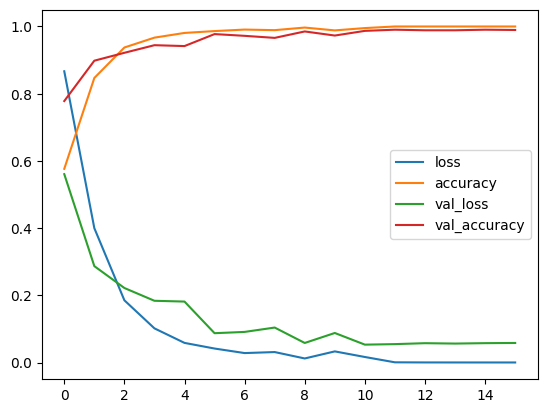

In [233]:
# Learning curves

result_df.plot()
plt.show()

In [36]:
# Evaluating the model on train set

loss, acc = model.evaluate(X_train, y_train)

204/204 [==============================] - 1s 7ms/step - loss: 2.2343e-04 - accuracy: 1.0000


In [37]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 [==============================] - 1s 5ms/step
tf.Tensor(
[[2169    0    0]
 [   0 2169    0]
 [   0    0 2168]], shape=(3, 3), dtype=int32)


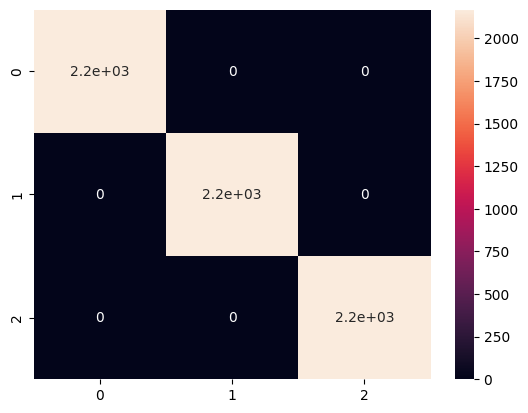

In [236]:
sns.heatmap(cm, annot = True)
plt.show()

In [237]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2169
True Negatives : 4337
False Positives : 0
False Negatives : 0

Precision : 1.0
Recall (Sensitivity) : 1.0
F1-Score : 1.0


Class CI : 

True Positives : 2169
True Negatives : 4337
False Positives : 0
False Negatives : 0

Precision : 1.0
Recall (Sensitivity) : 1.0
F1-Score : 1.0


Class CN : 

True Positives : 2168
True Negatives : 4338
False Positives : 0
False Negatives : 0

Precision : 1.0
Recall (Sensitivity) : 1.0
F1-Score : 1.0


In [238]:
# Classification Report

clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169
           1       1.00      1.00      1.00      2169
           2       1.00      1.00      1.00      2168

    accuracy                           1.00      6506
   macro avg       1.00      1.00      1.00      6506
weighted avg       1.00      1.00      1.00      6506



### Model Validation

In [239]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 [==============================] - 0s 6ms/step - loss: 0.1521 - accuracy: 0.9859


43/43 [==============================] - 0s 5ms/step


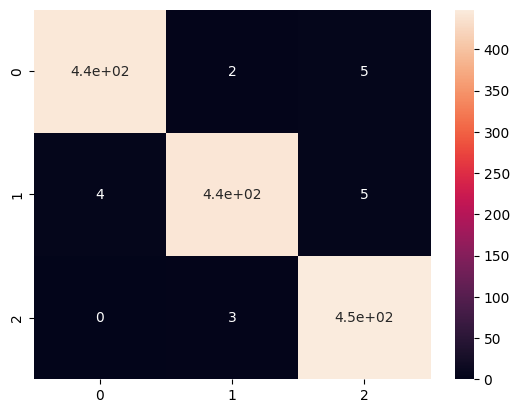

In [240]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [242]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 443
True Negatives : 897
False Positives : 4
False Negatives : 7

Precision : 0.9910514541387024
Recall (Sensitivity) : 0.9844444444444445
F1-Score : 0.9877369007803789


Class CI : 

True Positives : 441
True Negatives : 896
False Positives : 5
False Negatives : 9

Precision : 0.9887892376681614
Recall (Sensitivity) : 0.98
F1-Score : 0.984375


Class CN : 

True Positives : 448
True Negatives : 890
False Positives : 10
False Negatives : 3

Precision : 0.9781659388646288
Recall (Sensitivity) : 0.9933481152993349
F1-Score : 0.9856985698569858


In [243]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       450
           1       0.99      0.98      0.98       450
           2       0.98      0.99      0.99       451

    accuracy                           0.99      1351
   macro avg       0.99      0.99      0.99      1351
weighted avg       0.99      0.99      0.99      1351



### Saving the Model

36/36 [==============================] - 0s 6ms/step
Classification Report - Validation Set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       383
           1       0.99      0.99      0.99       383
           2       0.99      0.98      0.99       383

    accuracy                           0.99      1149
   macro avg       0.99      0.99      0.99      1149
weighted avg       0.99      0.99      0.99      1149

43/43 [==============================] - 0s 7ms/step


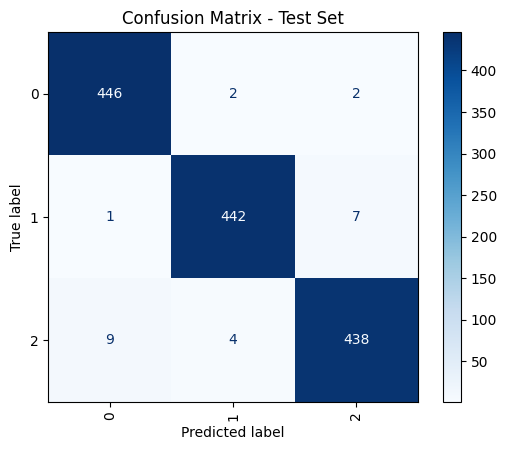

Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       450
           1       0.99      0.98      0.98       450
           2       0.98      0.97      0.98       451

    accuracy                           0.98      1351
   macro avg       0.98      0.98      0.98      1351
weighted avg       0.98      0.98      0.98      1351



In [42]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Evaluate the model on the validation set
X_train, X_val, y_train, y_val  # Ensure these are properly defined earlier in your script.
valid_predictions = np.argmax(model.predict(X_val), axis=1)

# Generate unique class names based on the dataset
unique_classes = sorted(np.unique(y_val))
target_names = [str(cls) for cls in unique_classes]  # Ensure these match your class labels.

# Classification report for validation set
print("Classification Report - Validation Set:")
print(classification_report(y_val, valid_predictions, labels=unique_classes, target_names=target_names))

# Evaluate the model on the test set
test_predictions = np.argmax(model.predict(X_test), axis=1)

# Generate the confusion matrix
unique_classes_test = sorted(np.unique(np.concatenate([y_test, test_predictions])))
conf_matrix = confusion_matrix(y_test, test_predictions, labels=unique_classes_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_classes_test)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Set")
plt.show()

# Classification report for test set
print("Classification Report - Test Set:")
print(classification_report(y_test, test_predictions, labels=unique_classes_test, target_names=[str(cls) for cls in unique_classes_test]))


In [250]:
model.save("clf_model_final.h5")